In [ ]:
#@title installing libs for custom environment
!pip uninstall tensorflow -y
!pip install tensorflow==1.6

!pip install stable-baselines
# !pip install keras-rl

In [ ]:
#@title  Basic Classes
import numpy as np
import math, random

# from google.colab import drive 
# drive.mount('/content/gdrive')

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [6,3]#[15, 10]
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

class Component:
  def __init__(self, id, mttf, mttr):
    self.id = id
    self.mttf = float(mttf)
    self.mttr = float(mttr)
    self.availability = self.mttf/(self.mttf+self.mttr)
    self.init_tme = 0

    self.next_failure_event = 0
    self.next_repair_event = 0
    self.operational = True

  def generate_next_failure_event(self):
    self.next_failure_event = np.random.exponential(self.mttf)
    return self.next_failure_event

  def generate_next_repair_event(self):
    self.next_repair_event = np.random.exponential(self.mttr)
    return self.next_repair_event


class VM(Component):
  def __init__(self, id, mttf, mttr, sfc_id, vnf_template_id,server_id,dc_id):
    super().__init__(id, mttf, mttr)
    self.sfc_id = sfc_id
    self.vnf_template_id = vnf_template_id
    self.server_id = server_id
    self.dc_id = dc_id

    

class Server(Component):
  def __init__(self, id, mttf, mttr, vms, resources, energy_consumption, vm_mttf, vm_mttr,dc_id):
    super().__init__(id, mttf, mttr)
    self.vms = vms
    self.vms_number = len(self.vms)
    self.resources = resources
    self.original_resources = resources
    self.energy_consumption = energy_consumption
    self.vm_mttf = vm_mttf
    self.vm_mttr = vm_mttr
    self.dc_id = dc_id

class DC:
  def __init__(self, id, servers, links):
    self.id = id
    self.servers = servers
    self.links = links

class VNF_template:
  def __init__(self, id, name, cost):
    self.id = id
    self.name = name
    self.cost = cost

class SFC_template:
  def __init__(self, id, vnf_templates):
    self.id = id
    self.vnf_templates_id = vnf_templates

class SFC:
  def __init__(self, id, vm_ids, customer_id, sfc_template):
    self.id = id
    self.vm_ids = vm_ids # [(dc_id, server_id, vm_id)]
    self.customer_id = customer_id
    self.sfc_template = sfc_template


class Request:
  def __init__(self, customer_id, time, vnf_template_id, sfc_template_id, availability_threshold, departure_time, last_vnf):
    # print('customer_id',customer_id, 'time',time, 'vnf_template_id',vnf_template_id, 
    #       'sfc_template_id',sfc_template_id, 'availability_threshold',availability_threshold,'departure_time' ,departure_time,
    #       'last_vnf',last_vnf)
    
    self.customer_id = customer_id
    self.time = time
    self.vnf_template_id = vnf_template_id
    self.sfc_template_id = sfc_template_id
    self.availability_threshold = availability_threshold
    self.last_vnf = last_vnf
    self.departure_time = departure_time

class Customer:
  def __init__(self, id, sfc_templates, arrival_rate, 
               departure_rate, availability_threshold, traffic_flow):
    self.id = id
    self.sfc_templates = sfc_templates
    self.arrival_rate = arrival_rate
    self.departure_rate = departure_rate
    self.availability_threshold = availability_threshold
    self.traffic_flow = traffic_flow

  def next_time(self, rate):
    # https://towardsdatascience.com/the-poisson-process-everything-you-need-to-know-322aa0ab9e9a
    # https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/
    return -math.log(1.0 - random.random()) / rate
    
  def generate_requests(self, period_duration):
    t = 0
    number_of_requests = 0

    requests = []
    departure_events = []
    
    while t <= period_duration:
      new_request_time = (self.next_time(self.arrival_rate))
      new_departure_time = (self.next_time(self.departure_rate)) # this departure time will be used only if this request will be meeted by the agent
      
      # print('new_request_time',new_request_time,'new_departure_time',new_departure_time)
      # print('time:',t,'number of requests:',number_of_sfc_requests)
      
      number_of_requests += 1

      #print("arrival:",new_request_time,"departure:", new_departure_time)
      t += new_request_time
      new_request_time = t
      t += new_departure_time
      new_departure_time = t 

      for j, sfc_template in enumerate(self.sfc_templates):
        for i, vnf_template_id in enumerate(sfc_template.vnf_templates_id):
          if i == (len(sfc_template.vnf_templates_id)-1):
            # print(self.id, new_request_time, vnf_template_id, sfc_template.id, self.availability_threshold, new_departure_time)
            request = Request(self.id, new_request_time, vnf_template_id, sfc_template.id, self.availability_threshold, new_departure_time, True)
          else:
            # print(self.id, new_request_time, vnf_template_id, sfc_template.id, 0, new_departure_time)
            request = Request(self.id, new_request_time, vnf_template_id, sfc_template.id, self.availability_threshold, new_departure_time, False)
          requests.append(request)
      
    return requests, number_of_requests

class Release_event:
  def __init__(self, time, sfc_id, type):
    self.time = time
    self.sfc_id = sfc_id
    self.type = type

class Event:
  def __init__(self, time, dc_id, server_id, vm_id, type):
    self.time = time
    self.dc_id = dc_id
    self.server_id = server_id
    self.vm_id = vm_id
    self.type = type

# sfc_template = SFC_template(id=0,vnf_templates=[0,1])
# customer1 = Customer(0,[sfc_template] , float(1/10), float(1/5), 0.95, traffic_flow={})
# r = customer1.generate_requests(100)


In [ ]:
#@title Scenario class (Simulator)
from operator import attrgetter
from itertools import combinations, combinations_with_replacement
import copy

class Potential_SFC:
  def __init__(self,customer_id, sfc_template, vms_location,temp_vms):
    self.customer_id = customer_id
    self.sfc_template = sfc_template
    self.vms_location = vms_location
    self.temp_vms = temp_vms

class Scenario:
  def generate_random_range(self,value,percentage):
    maximum = value+(value*percentage)
    minimum = value-(value*percentage)
    
    return random.uniform(minimum,maximum)
  
  def generate_random_scenario_component(self,scenario_configuration,key,porc):
    component_list = []
    for component_value in scenario_configuration[key]:
      component_list.append(self.generate_random_range(component_value,porc))
    return component_list


  def generate_random_scenario(self,scenario_configuration):
    
    random_scenario_configuration = {}

    # FIXED
    fixed_keys = ['print_log','dcs','servers','resources','vnf_templates','period_duration']
    fixed_keys += ['servers_mttf','servers_mttr','vms_mttf','vms_mttr','energy_consumption']
    
    for key in fixed_keys:
      random_scenario_configuration[key] = scenario_configuration[key]

    # components_to_variate = ['servers_mttf','servers_mttr','vms_mttf','vms_mttr','energy_consumption']
    # for component in components_to_variate:
    #   random_scenario_configuration[component] = self.generate_random_scenario_component(scenario_configuration,component,scenario_configuration['percentage_variation'] )
    
    #Generating customers
    customers = []
    random_scenario_configuration['customers'] = []
    vnf_template_ids = list(range(len(scenario_configuration['vnf_templates'])))
    
    for x in range(scenario_configuration['customers_number']):
      number_of_vnfs = random.randint(2,len(scenario_configuration['vnf_templates']))
      customer = {}
      vnf_template_list = random.sample(vnf_template_ids,number_of_vnfs)
      customer['sfc_templates'] = [{'vnf_templates':vnf_template_list}]

      customer['arrival_rate'] = self.generate_random_range(scenario_configuration['customers'][0]['arrival_rate'],scenario_configuration['percentage_variation'] )
      customer['departure_rate'] = self.generate_random_range(scenario_configuration['customers'][0]['departure_rate'],scenario_configuration['percentage_variation'] )
      
      if scenario_configuration['generate_av_threshold']:
        av_threshold = self.generate_random_range(scenario_configuration['customers'][0]['availability_threshold'],scenario_configuration['percentage_variation'])
        
      else:
        av_threshold = scenario_configuration['customers'][0]['availability_threshold']
        
      
      if av_threshold >= 1:
        customer['availability_threshold'] = 0.999999
      else:
        customer['availability_threshold'] = av_threshold

      customer['traffic_flow'] = scenario_configuration['customers'][0]['traffic_flow']

      customers.append(customer)
      
    random_scenario_configuration['customers'] = customers

    return random_scenario_configuration

  def __init__(self,scenario_configuration):
    self.maximum_redundant_vms = scenario_configuration['maximum_redundant_vms']
    self.print_log = scenario_configuration['print_log']

    self.scenario_configuration = scenario_configuration

    # to use a fixed scenario, comment the following line
    scenario_configuration = self.generate_random_scenario(scenario_configuration)

    dcs = []
    vnf_templates = []
    customers = []
    
    dc_ids = list(range(scenario_configuration['dcs']))

    for i in dc_ids:
      servers = []
      for j in range(scenario_configuration['servers'][i]):
        
        server = Server(id=j,mttf=scenario_configuration['servers_mttf'][i],
                        mttr=scenario_configuration['servers_mttr'][i],vms=[],
                        resources=scenario_configuration['resources'][i],
                        energy_consumption=scenario_configuration['energy_consumption'][i],
                        vm_mttf=scenario_configuration['vms_mttf'][i],
                        vm_mttr=scenario_configuration['vms_mttr'][i],dc_id=i)
        servers.append(server)
      dc = DC(id=i,servers=servers,links=[x for x in dc_ids if x!=i])
      dcs.append(dc)
    
    for i, vnf_template_conf in enumerate(scenario_configuration['vnf_templates']):
      vnf_template = VNF_template(id=i,name=vnf_template_conf['name'],cost=vnf_template_conf['cost'])
      vnf_templates.append(vnf_template)
    
    for i, customer_conf in enumerate(scenario_configuration['customers']):
      
      sfc_templates = []
      for j, sfc_template_conf in enumerate(customer_conf['sfc_templates']):
        sfc_templates.append(SFC_template(id=j,vnf_templates=sfc_template_conf['vnf_templates']))
        
      customer = Customer(id=i,sfc_templates=sfc_templates,
                          arrival_rate=customer_conf['arrival_rate'],
                          departure_rate=customer_conf['departure_rate'],
                          availability_threshold=customer_conf['availability_threshold'],
                          traffic_flow=customer_conf['traffic_flow'])
      customers.append(customer)
    
    self.create_scenario(dcs,vnf_templates,customers,scenario_configuration['period_duration'])
    

  ### METHODS  
  def create_scenario(self, dcs, vnf_templates, customers, period_duration):
    self.dcs = dcs
    self.vnf_templates = vnf_templates
    self.customers = customers
    self.period_duration = period_duration
    
    self.current_step = 0
    self.sfcs_allocated = []
    self.potential_sfc = Potential_SFC(customer_id=-1, sfc_template=[], vms_location=[],temp_vms=[])
    
    self.requests, self.number_of_sfc_requests = self.generate_requests_from_customers()
    self.sfc_ids_list = list(range(self.number_of_sfc_requests))
    
    # print('CRIANDO O CENARIO')
    # for i,req in enumerate(self.requests):
    #   print(i,'time:',req.time,'release:',req.departure_time,'av:',req.availability_threshold,'vnf_template_id',req.vnf_template_id,'customer_id',req.customer_id)

    self.events_to_happen = self.generate_first_failures_servers()
    # self.release_events_to_happen = []

    self.servers_map = {}
    self.servers_number = 0
    for dc in self.dcs:
      for server in dc.servers:
        self.servers_map[self.servers_number] = (dc.id, server.id)
        self.servers_number += 1

    # metrics
    self.sfc_ids_failed = []
    self.customers_impacted = {}
    self.number_of_sfc_requests_sucess = 0
    self.number_of_sfc_requests_sucess_sla_broken = 0
    self.sfc_ids_impacted = []
    self.cumulated_sfc_energy_consumption = 0
    self.acceptance_ratio = []
    self.current_number_of_sfc_requests = 0
  
  def sort_object_list(self,events,key): # key is the attribute of object that will be used to sort te list
    events.sort(key=attrgetter(key), reverse=False)
    return events

  def generate_first_failures_servers(self):
    failures = []

    for i, dc in enumerate(self.dcs):
      for j, server in enumerate(dc.servers):
        failure_time = server.generate_next_failure_event()
        event = Event(failure_time, dc.id, server.id,-1,'failure')
        failures.append(event)
    
    failures = self.sort_object_list(failures,'time')

    # for failure in failures:
    #   print('time:',failure.time,'DC id:',failure.dc_id,'server id:',failure.server_id,'type:',failure.type)
    return failures

  def generate_requests_from_customers(self):
    current_requests = []
    number_of_requests = 0
    
    for i, customer in enumerate(self.customers):
      tmp_requests, temp_number_of_requests = customer.generate_requests(self.period_duration)
      
      # print(len(tmp_requests))
      # for r in tmp_requests:
      #   print('customer id:',r.customer_id,'arrival:',r.time,'departure:',r.departure_time, 'vnf template:', r.vnf_template_id, 'av:',r.availability_threshold)
      
      current_requests = current_requests + tmp_requests
      number_of_requests = number_of_requests + temp_number_of_requests
          
    current_requests = self.sort_object_list(current_requests,'time')

    return current_requests, number_of_requests
  


  def process_events(self, time_evaluation): #this time is the time of current request
    events_to_be_processed_now = []
    indexes_to_delete = []
    
    # print('\n\n------ TODOS OS EVENTOS 1 ------')
    
    # for ev in self.events_to_happen:
    #   if ev.type == 'release':
    #     for sfc in self.sfcs_allocated:
    #       if ev.sfc_id == sfc.id:
    #         print('Time:',ev.time,'type: release SFC id:',ev.sfc_id,sfc.vm_ids)
    #   else:
    #     print('Time:',ev.time,'type',ev.type,'DC:',ev.dc_id,'server:',ev.server_id,'vm:',ev.vm_id)

    # print('------ TODOS OS EVENTOS 2 ------')

    # #LOG
    if self.print_log:
      print('-> time_evaluation:',time_evaluation)

    for i, ev in enumerate(self.events_to_happen):
      if ev.time <= time_evaluation:
        
        # LOG
        if self.print_log:
          if ev.type == 'release':
            for sfc in self.sfcs_allocated:
              if ev.sfc_id == sfc.id:
                print('events for NOW:',ev.time,'type: release SFC id:',ev.sfc_id,sfc.vm_ids)
          else:
            print('events for now:',ev.time,'type',ev.type,'DC:',ev.dc_id,'server:',ev.server_id,'vm:',ev.vm_id)
            
        events_to_be_processed_now.append(ev)
        indexes_to_delete.append(i)
      else:
        break

    temp_list = []
    for x in range(len(self.events_to_happen)):
      if x not in indexes_to_delete:
        temp_list.append(self.events_to_happen[x])
    
    self.events_to_happen = temp_list #removing events that will happen now

    #generating new events to be processed (now and in the future) from the events to be processed now
    new_events_for_future = []
    new_events_to_be_processed_now = []

    for ev in events_to_be_processed_now:
      
      if ev.type != 'failure' and ev.type != 'repair':
        continue

      generate_new_events = True
      current_event = ev
      
      while generate_new_events:
        
        if current_event.type == 'failure': #failure events
          repairtime = 0
          if current_event.vm_id == -1: # server failure
            repairtime = self.dcs[current_event.dc_id].servers[current_event.server_id].generate_next_repair_event()
            
          else: # vm failure
            for i, vm in enumerate(self.dcs[current_event.dc_id].servers[current_event.server_id].vms):
              if vm.id == current_event.vm_id:
                repairtime = self.dcs[current_event.dc_id].servers[current_event.server_id].vms[i].generate_next_repair_event()
                break
          
          repairtime = current_event.time + repairtime
          
          temp_event = Event(time=repairtime,dc_id=current_event.dc_id,type='repair',
                                     server_id=current_event.server_id,vm_id=current_event.vm_id)
          
          if repairtime > time_evaluation: # event for the future
            new_events_for_future.append(temp_event)
            generate_new_events = False
                      
          else: # event for now
            new_events_to_be_processed_now.append(temp_event)
            current_event = temp_event
        
        elif current_event.type == 'repair': # repair events
          failuretime = 0
          if current_event.vm_id == -1: #server repair
            failuretime = self.dcs[current_event.dc_id].servers[current_event.server_id].generate_next_failure_event()
          
          else: # vm repair
            for i, vm in enumerate(self.dcs[current_event.dc_id].servers[current_event.server_id].vms):
              if current_event.vm_id == vm.id:
                failuretime = self.dcs[current_event.dc_id].servers[current_event.server_id].vms[i].generate_next_failure_event()
                break
          
          failuretime = current_event.time + failuretime
          
          temp_event = Event(time=failuretime,dc_id=current_event.dc_id,type='failure',
                                     server_id=current_event.server_id,vm_id=current_event.vm_id)

          if failuretime > time_evaluation: # event for the future
            new_events_for_future.append(temp_event)
            generate_new_events = False
          
          else: # events for now
            new_events_to_be_processed_now.append(temp_event)
            current_event = temp_event
        
    # adding future events in the queue
    self.events_to_happen = self.events_to_happen + new_events_for_future
    self.events_to_happen = self.sort_object_list(self.events_to_happen,'time')

    

    # solving the events to be processed now
    if len(new_events_to_be_processed_now) > 0:
      events_to_be_processed_now = events_to_be_processed_now + new_events_to_be_processed_now
      events_to_be_processed_now = self.sort_object_list(events_to_be_processed_now,'time')

    failures_now = 0

    for ev in events_to_be_processed_now:
      
      if ev.type == 'failure': # failure events
        # failures_now += 1 # all failures

        if ev.vm_id == -1: #server failure
          failures_now += 1
          self.dcs[ev.dc_id].servers[ev.server_id].operational = False
          # self.dcs[ev.dc_id].servers[ev.server_id].resources = 0
          for vm in self.dcs[ev.dc_id].servers[ev.server_id].vms: # all VMs of this server will become unavailable
            vm.operational = False
            self.remove_failure_repair_events(ev.dc_id, ev.server_id, vm.id, time_evaluation)

        else: #vm failure
          for i in range(len(self.dcs[ev.dc_id].servers[ev.server_id].vms)):
            if self.dcs[ev.dc_id].servers[ev.server_id].vms[i].id == ev.vm_id:
              self.dcs[ev.dc_id].servers[ev.server_id].vms[i].operational = False
              
              #self.remove_failure_repair_events(ev.dc_id, ev.server_id, self.dcs[ev.dc_id].servers[ev.server_id].vms[i].id, time_evaluation)

              break
          
      elif ev.type == 'repair': #repair events
        
        if ev.vm_id == -1: #server repair
          self.dcs[ev.dc_id].servers[ev.server_id].operational = True
          self.dcs[ev.dc_id].servers[ev.server_id].init_time = ev.time
          
          new_vm_failures_events = []
          # cosumed_resources = 0
          for vm in self.dcs[ev.dc_id].servers[ev.server_id].vms: #making the VMs operational again
            vm.operational = True
            vm.init_time = ev.time

            time_failure = ev.time+vm.generate_next_failure_event()
            event = Event(time_failure,ev.dc_id,ev.server_id,vm.id,'failure')
            new_vm_failures_events.append(event)
            # cosumed_resources += self.vnf_templates[vm.vnf_template_id].cost
          
          # self.dcs[ev.dc_id].servers[ev.server_id].resources = self.dcs[ev.dc_id].servers[ev.server_id].original_resources - cosumed_resources
          self.events_to_happen += new_vm_failures_events
          self.events_to_happen = self.sort_object_list(self.events_to_happen,'time')
        
        else: # vm repair
          for i in range(len(self.dcs[ev.dc_id].servers[ev.server_id].vms)):
            if self.dcs[ev.dc_id].servers[ev.server_id].vms[i].id == ev.vm_id:
              self.dcs[ev.dc_id].servers[ev.server_id].vms[i].operational = True
              self.dcs[ev.dc_id].servers[ev.server_id].vms[i].init_time = ev.time
              
              # time_failure = ev.time + self.dcs[ev.dc_id].servers[ev.server_id].vms[i].generate_next_failure_event()
              # event = Event(time_failure,ev.dc_id,ev.server_id,ev.vm_id,'failure')
              # self.events_to_happen += [event]
              # self.events_to_happen = self.sort_object_list(self.events_to_happen,'time')

              break
      
      elif ev.type == 'release': # release event
        vms_to_remove = []
        # self.print_dcs_status()
        # print('##### release')

        for i in range(len(self.sfcs_allocated)):
          if self.sfcs_allocated[i].id == ev.sfc_id:
            sfc = self.sfcs_allocated.pop(i)
            vms_to_remove += sfc.vm_ids
            break

        
        # removing VMs and their failure and repair events:
        for dc_id, server_id, vm_id in vms_to_remove:
          for dc_i, dc in enumerate(self.dcs):
            if dc.id == dc_id:
              for server_i, server in enumerate(dc.servers):
                if server.id == server_id:
                  for vm_i, vm in enumerate(server.vms):
                    if vm.id == vm_id:
                      vm = self.dcs[dc_i].servers[server_i].vms.pop(vm_i) # removing the vm from server

                      self.remove_failure_repair_events(dc.id, server.id, vm.id, time_evaluation)
                      
                      if self.print_log:
                        print('before release:', dc_i,server_i,vm_id,'resources server:',self.dcs[dc_i].servers[server_i].resources,'vm cost:',self.vnf_templates[vm.vnf_template_id].cost)
                      
                      self.dcs[dc_i].servers[server_i].resources += self.vnf_templates[vm.vnf_template_id].cost
                      
                      if self.print_log:
                        print('after release:', dc_i,server_i,vm_id,'resources server:',self.dcs[dc_i].servers[server_i].resources,'vnf cost',self.vnf_templates[vm.vnf_template_id].cost)

                        # self.print_dcs_status()

                      break # vm
                  break # server
              break # dc
        # self.print_dcs_status()

    ## LOG
    if self.print_log:
      for ev in self.events_to_happen:
        if ev.type == 'release':
          for sfc in self.sfcs_allocated:
            if ev.sfc_id == sfc.id:
              print('events for FUTURE:',ev.time,'type: release SFC id:',ev.sfc_id,sfc.vm_ids)
        else:  
          print('events for future:',ev.time,'type',ev.type,'DC:',ev.dc_id,'server:',ev.server_id,'vm:',ev.vm_id)
          

    # verifying vms failed and registering the customers and sfcs impacted
    for sfc_allocated in self.sfcs_allocated:
      operational_vnf_templates_ids = []
      
      for dc_id, server_id, vm_id in sfc_allocated.vm_ids:
        for vm in self.dcs[dc_id].servers[server_id].vms:
          
          if vm.id == vm_id and vm.operational:
            operational_vnf_templates_ids.append(vm.vnf_template_id)
            break
      
      if (not all(vnf_template_id in operational_vnf_templates_ids for vnf_template_id in sfc_allocated.sfc_template.vnf_templates_id)) and (sfc_allocated.id not in self.sfc_ids_impacted):
        
        self.sfc_ids_impacted.append(sfc_allocated.id)

        if sfc_allocated.customer_id not in self.customers_impacted:
          self.customers_impacted[sfc_allocated.customer_id] = 1
        else:
          self.customers_impacted[sfc_allocated.customer_id] += 1
    
    
    return failures_now

################################################################################################################################################################

  def process_request(self,customer_id, time, server_unique_ids, vnf_template_id, sfc_template_id, availability_threshold, departure_time, last_vnf):
    failures = self.process_events(time)

    sfc_availability = 0  
    sfc_energy_consumption = 0
    # if availability_threshold > 0:

    unavailable_server_resources = False

    for i,server_unique_id in enumerate(server_unique_ids):
      dc_id = self.servers_map[server_unique_id][0]
      server_id = self.servers_map[server_unique_id][1]

      temp_vm = VM(id=0, mttf=self.dcs[dc_id].servers[server_id].vm_mttf, 
                   mttr=self.dcs[dc_id].servers[server_id].vm_mttr, sfc_id=0, 
                   vnf_template_id=vnf_template_id,server_id=server_id,dc_id=dc_id)
      
      if self.print_log:
        print('vnf cost',self.vnf_templates[vnf_template_id].cost,'name',self.vnf_templates[vnf_template_id].name,'id',self.vnf_templates[vnf_template_id].id)
      
      if self.potential_sfc.customer_id == -1:
        self.potential_sfc.customer_id = customer_id
        self.potential_sfc.sfc_template = self.customers[customer_id].sfc_templates[sfc_template_id]
      
      if self.dcs[dc_id].servers[server_id].resources >= self.vnf_templates[vnf_template_id].cost and self.dcs[dc_id].servers[server_id].operational:
        self.potential_sfc.temp_vms.append(temp_vm)
        self.dcs[dc_id].servers[server_id].resources -= self.vnf_templates[vnf_template_id].cost
      else:
        unavailable_server_resources = True

      
    if last_vnf:
      sfc_availability, sfc_energy_consumption = self.create_sfc(self.customers[customer_id].id,time, departure_time, availability_threshold)

      self.potential_sfc = Potential_SFC(customer_id=-1, sfc_template=[], vms_location=[],temp_vms=[])

      if self.print_log:
        print('sfc_availability',sfc_availability,'availability_threshold',availability_threshold,'last_vnf',last_vnf)

      if sfc_availability >= availability_threshold:
        self.number_of_sfc_requests_sucess += 1
        self.cumulated_sfc_energy_consumption += sfc_energy_consumption

      elif sfc_availability < availability_threshold and sfc_availability > 0:
        self.number_of_sfc_requests_sucess_sla_broken += 1

      # if sfc_availability > 0:
      #   self.cumulated_sfc_energy_consumption += sfc_energy_consumption

      self.current_number_of_sfc_requests += 1
      self.acceptance_ratio.append(self.number_of_sfc_requests_sucess/self.current_number_of_sfc_requests)

    return sfc_availability, sfc_energy_consumption, failures,unavailable_server_resources
      

  

  def create_sfc(self, customer_id, time, departure_time, availability_requirement):
    sfc_id = len(self.sfcs_allocated)
    customer = self.customers[customer_id]
    # sfc_template, customer_id, [vm_id], sfc_id

    sfc_availability = -1
    sfc_energy_consumption = 1000000
    
    vnfs_id_temp = [vm.vnf_template_id for vm in self.potential_sfc.temp_vms]
    current_vnfs_sfc = []
    [current_vnfs_sfc.append(x) for x in vnfs_id_temp if x not in current_vnfs_sfc]
    
    # checking if all vnfs from sfc were allocated
    sfc_complete = all(item in current_vnfs_sfc for item in customer.sfc_templates[0].vnf_templates_id)
    
    # print(customer.sfc_templates[0].vnf_templates_id)
    # print(customer.sfc_templates[0].vnf_templates_id,current_vnfs_sfc,sfc_complete)
    
    if not sfc_complete: # SFC incomplete
      self.remove_temp_vms_from_servers(delete_vms=False)

    else: # SFC complete, create the VMs in the servers and the respective events
      # self.number_of_sfc_requests_sucess += 1

      current_sfc_id = self.sfc_ids_list.pop(0) # removing the first component of list to be the SFC id

      if self.print_log:
        print('Creating SFC id:',current_sfc_id)

      current_vms_ids = []

      new_vm_failures_events = []
      # for i, (dc_id,server_id) in enumerate(temp_locations): # len(temp_locations) == len(vms_to_allocate)
      for i, vm in enumerate(self.potential_sfc.temp_vms):
        
        # vms_to_allocate[i].id = len(self.dcs[dc_id].servers[server_id].vms)
        if len(self.dcs[vm.dc_id].servers[vm.server_id].vms) > 0:
          vm_id_max = max(self.dcs[vm.dc_id].servers[vm.server_id].vms, key=attrgetter('id'))
          vm_id_max = vm_id_max.id + 1
        else:
          vm_id_max = 0

        vm.id = vm_id_max # selecting the max ID value + 1
        
        current_vms_ids.append((vm.dc_id, vm.server_id,vm_id_max))
        
        vm.sfc_id = current_sfc_id
        
        failuretime = time + vm.generate_next_failure_event() 
        event = Event(time=failuretime,dc_id=vm.dc_id,type='failure',
                                     server_id=vm.server_id,vm_id=vm.id)
        
        new_vm_failures_events.append(event)
        self.dcs[vm.dc_id].servers[vm.server_id].vms.append(copy.deepcopy(vm))
        # self.dcs[dc_id].servers[server_id].vms.append(vms_to_allocate[i])
      
      sfc_availability = self.calc_sfc_availability(self.potential_sfc.temp_vms) #vms_to_allocate)
      
      if sfc_availability < availability_requirement:
        self.remove_temp_vms_from_servers(delete_vms=True)

      else:
        # sfc_energy_consumption = self.calc_sfc_energy_consumption(self.potential_sfc.temp_vms)
        sfc_energy_consumption = self.calc_sfc_energy_consumption_servers(self.potential_sfc.temp_vms)
        
        self.events_to_happen += new_vm_failures_events
        self.events_to_happen = self.sort_object_list(self.events_to_happen,'time')
        

        #creating the SFC
        sfc = SFC(id=current_sfc_id, vm_ids=current_vms_ids, customer_id=customer_id, 
                  sfc_template=self.potential_sfc.sfc_template)
        
        self.sfcs_allocated.append(sfc)

        release_event = Release_event(time=departure_time, sfc_id=current_sfc_id, type='release')
        # self.release_events_to_happen.append(release_event)
        # self.release_events_to_happen = self.sort_object_list(self.release_events_to_happen,'time')
        
        self.events_to_happen.append(release_event)
        self.events_to_happen = self.sort_object_list(self.events_to_happen,'time')
      
    return sfc_availability, sfc_energy_consumption

  def remove_temp_vms_from_servers(self,delete_vms):
    
    for vm in self.potential_sfc.temp_vms:
      self.dcs[vm.dc_id].servers[vm.server_id].resources += self.vnf_templates[vm.vnf_template_id].cost
      
      if delete_vms:
        for i in range(len(self.dcs[vm.dc_id].servers[vm.server_id].vms)):
          if self.dcs[vm.dc_id].servers[vm.server_id].vms[i].id == vm.id:
            self.dcs[vm.dc_id].servers[vm.server_id].vms.pop(i)
            break


        
  def calc_sfc_availability(self, vms): #, locations):
    overall_availavility = 1
    
    locations = [(vm.dc_id,vm.server_id) for vm in vms]
    server_vms = {}
    
    # gathering all vms of the same server
    for i, loc in enumerate(locations):
      if loc not in server_vms:
        server_vms[loc] = [vms[i]]
      else:
        server_vms[loc].append(vms[i])

    for loc in server_vms:
      vms_av = self.calc_vms_availability(server_vms[loc])
      overall_availavility *= self.dcs[loc[0]].servers[loc[1]].availability * vms_av

    
    return overall_availavility

  def calc_vms_availability(self, vms):
    vms_av = 1
    
    #calc vms availability
    rbd = {}
    for vm in vms:
      if vm.vnf_template_id not in rbd:
        rbd[vm.vnf_template_id] = [vm]
      else:
        rbd[vm.vnf_template_id].append(vm)
    
    for key in rbd:
      if len(rbd[key])>1: #parallel vms
        temp_av = 1
        for vm in rbd[key]:
          temp_av *= (1 - vm.availability)
        
        vms_av *= (1 - temp_av)
        
      else: # series vms
        vms_av *= rbd[key][0].availability
            
    return vms_av

  def calc_sfc_energy_consumption(self, vms):
    sfc_energy_consumption = 0
    locations = [(vm.dc_id,vm.server_id) for vm in vms]

    for dc_id,server_id in locations:
      if self.dcs[dc_id].servers[server_id].operational:
        sfc_energy_consumption += self.dcs[dc_id].servers[server_id].energy_consumption
    
    return sfc_energy_consumption

  def calc_sfc_energy_consumption_servers(self, vms):
    sfc_energy_consumption = 0

    memory_servers = []
    for vm in vms:
      if self.dcs[vm.dc_id].servers[vm.server_id].operational and (vm.dc_id,vm.server_id) not in memory_servers:
        sfc_energy_consumption += self.dcs[vm.dc_id].servers[vm.server_id].energy_consumption
        memory_servers.append((vm.dc_id,vm.server_id))
    
    return sfc_energy_consumption


  def remove_failure_repair_events(self, dc_id, server_id, vm_id, time_evaluation):
    
    events_for_future = []
    for i, event in enumerate(self.events_to_happen):
      if not (event.type == 'repair' or event.type == 'failure'):
        events_for_future.append(event)
        continue
      if not (event.dc_id == dc_id and event.server_id == server_id and event.vm_id == vm_id):
        events_for_future.append(event)
      
    self.events_to_happen = self.sort_object_list(events_for_future,'time')
    

  def print_dcs_status(self):
    print('****************************************')
    for dc in self.dcs:
      print('dc:',dc.id)
      for server in dc.servers:
        print('server:',server.id, 'operational:',server.operational,'resources:',server.resources)
        for vm in server.vms:
          print('vm id:',vm.id,'sfc id:',vm.sfc_id, 'vnf template id:',vm.vnf_template_id)
      print('------------------')
    print('****************************************')

  def get_remaining_resources_servers(self):
    remaining_resources = []

    for dc in self.dcs:
      for server in dc.servers:
        if server.operational:
          remaining_resources.append(server.resources)
        else:
          remaining_resources.append(0)
        
    return remaining_resources
  
  def get_availabilities_servers(self):
    availabilities = []

    for dc in self.dcs:
      for server in dc.servers:
        availabilities.append(server.availability)
    
    return availabilities


# ------------------------------------------------------------------------------------------------------------------------------

#ordem: -> processar os releases das SFCs, processar os eventos de falha, processar os requests

scenario_configuration = {
    'percentage_variation':0.1,
    'dcs':1,
    'servers':[3], # servers per dc
    'resources':[100], # vm limit per dcs (for now, all servers are similar)
    'servers_mttf':[200],
    'servers_mttr':[1],
    'vms_mttf':[100],
    'vms_mttr':[1],
    'energy_consumption':[70],
    'maximum_redundant_vms':3,

    'vnf_templates':[
         {'name':'firewall','cost':1},
         {'name':'DPI','cost':1},
         {'name':'Antivirus','cost':2},
         {'name':'load_balancer','cost':3}
    ],
    'customers_number': 2,
    'generate_av_threshold': False,
    'customers':[
        {'sfc_templates':[{'vnf_templates':[0,1]}], 
          # 'arrival_rate':(1.0/10.0),
          # 'departure_rate':(1.0/5.0),
         'arrival_rate':(4/100),
         'departure_rate':(1/1000),
          'availability_threshold':0.95,
          'traffic_flow':{}}           
    ],
    'period_duration':8760,
    'print_log':False
}


scenario = Scenario(scenario_configuration)


possible_actions=[]
servers_ids = list(range(scenario.servers_number))
for x in range(len(servers_ids)):
  possible_actions += list(combinations(servers_ids,x+1))

print('number of requests:', len(scenario.requests))
for x in range(len(scenario.requests)):
  # action = possible_actions[random.randrange(len(possible_actions))]
  action = [random.randrange(scenario.servers_number),random.randrange(scenario.maximum_redundant_vms)]
  action = [action[0]] * (action[1]+1)
  
  r = scenario.requests[scenario.current_step]
  scenario.current_step += 1
  
  # resources_available = 0
  # for dc in scenario.dcs:
  #   for server in dc.servers:
  #     if server.operational:
  #       resources_available += server.resources
  # print('resources_available',resources_available)

  sfc_availability, sfc_energy_consumption, failures,unavailable_server_resources = scenario.process_request(customer_id=r.customer_id, time=r.time, server_unique_ids=action, vnf_template_id=r.vnf_template_id,
                           sfc_template_id=r.sfc_template_id, availability_threshold=r.availability_threshold,
                           departure_time=r.departure_time,last_vnf=r.last_vnf)
  

number of requests: 54


# Reinforcement Learning

This environement considers th action space as an integer vector with two positions. The first position represents the server id, while the second position represents the number of redundant VNFs that will be allocated

In [ ]:
#@title Environment Class
import gym
from gym import spaces
from itertools import combinations, combinations_with_replacement

from stable_baselines.common.env_checker import check_env

 # OpenAI gym spaces: https://github.com/openai/gym/blob/master/gym/spaces
path = ''

class My_environment(gym.Env):
  def __init__(self,scenario):
    self.scenario = scenario
    # self.current_step = 0
    # self.current_time = 0
    self.possible_actions = []

    self.max_cost =  max(vnf_temp.cost for vnf_temp in scenario.vnf_templates)
    self.min_cost =  min(vnf_temp.cost for vnf_temp in scenario.vnf_templates)

    # LOG
    self.resources_log = []
    self.cumulative_reward = 0
    self.cumulative_reward_list = []
    self.gt = 0
    self.gt_list = []

    # servers_ids = list(range(self.scenario.servers_number))
    
    # for x in range(len(servers_ids)):
    # for x in range(self.scenario.maximum_redundant_vms):
    #   combination = list(combinations(servers_ids,x+1))
    #   self.possible_actions += combination

    # self.action_space = spaces.Discrete(len(self.possible_actions))
    # self.action_space = spaces.MultiDiscrete([2]*len(servers_ids)) # [2] -> 0 or 1

    self.action_space = spaces.MultiDiscrete([self.scenario.servers_number,self.scenario.maximum_redundant_vms])
    
    self.max_resources_servers = 0
    for dc in self.scenario.dcs:
      for server in dc.servers:
        if self.max_resources_servers < server.resources:
          self.max_resources_servers = server.resources
    
    # number of servers (remaing resources each server) + 
    # number of servers (availability of each server) + REMOVED
    # VNF cost + 
    # availability requeriment REMOVED
    # self.observation_space = spaces.Box(low=0,high=100,shape=(self.scenario.servers_number+1,))
    self.observation_space = spaces.Box(low=0,high=100,shape=(self.scenario.servers_number*2+1+1,))
    
  def _next_observation(self):
    obs = []
    
    remaining_resources_servers = self.scenario.get_remaining_resources_servers()
    # normalizing between 0 and 1 
    # remaining_resources_servers = [(x-0)/(self.max_resources_servers-0) for x in remaining_resources_servers]
    obs += remaining_resources_servers

    obs += self.scenario.get_availabilities_servers() # REMOVED
    
    # #obs.append(self.scenario.requests[self.scenario.current_step].availability_threshold)
    request_temp = self.scenario.requests[self.scenario.current_step]
    
    vnf_cost = self.scenario.vnf_templates[request_temp.vnf_template_id].cost

    # normalizing between 0 and 1
    # vnf_cost = (vnf_cost-self.min_cost)/(self.max_cost-self.min_cost)
    obs.append(vnf_cost)
    obs.append(request_temp.availability_threshold) # REMOVED

    obs = np.asarray(obs)
    # obs = np.reshape(obs,self.observation_space.shape)
    # print(obs)
    return obs


  def step(self, action):
    # Execute one time step within the environment

    resources_available = 0
    for dc in self.scenario.dcs:
      for server in dc.servers:
        if server.operational:
          resources_available += server.resources
    self.resources_log.append(resources_available)

    # print('before:',action)
    # action = self.possible_actions[action]
    # action = [i for i, status in enumerate(action) if status == 1]
    action = [action[0]] * (action[1]+1)
    # print('action',action)

    request = self.scenario.requests[self.scenario.current_step]
    
    # self.scenario.process_releases_events(request.time)
    # failures = self.scenario.process_events(request.time)

    sfc_availability, sfc_energy_consumption, failures, unavailable_server_resources= self.scenario.process_request(customer_id=request.customer_id, time=request.time,
                                  server_unique_ids=action, vnf_template_id=request.vnf_template_id,
                                  sfc_template_id=request.sfc_template_id, 
                                  availability_threshold=request.availability_threshold,
                                  departure_time=request.departure_time,last_vnf=request.last_vnf)
    
    reward = 0
    
    if sfc_availability == 0:
      if unavailable_server_resources:
        reward = -1
    elif sfc_availability == -1:
      reward = -5
    else:
      if sfc_availability < request.availability_threshold:
        reward = (sfc_availability - request.availability_threshold)*2
      else:
        reward = (sfc_availability-request.availability_threshold)*100
        reward += 2 # a little bonus for the good availability
        reward -= (sfc_energy_consumption * 0.01)

    self.scenario.current_step += 1

    # print(sfc_availability,request.availability_threshold,sfc_energy_consumption)
    # print('action:',action,'cost:',self.scenario.vnf_templates[request.vnf_template_id].cost,'reward',reward)
    
    obs = self._next_observation()
    
    done = self.scenario.current_step == (len(self.scenario.requests)-1)
    
    # print('sfc_availability',sfc_availability,'sfc_energy_consumption',sfc_energy_consumption,'reward',reward)
    # self.scenario.current_step += 1
    
    # if reward != 0:
    # resources_available = 0
    # for dc in self.scenario.dcs:
    #   for server in dc.servers:
    #     if server.operational:
    #       resources_available += server.resources
    # self.resources_log.append(resources_available)

    self.cumulative_reward += reward
    self.cumulative_reward_list.append(self.cumulative_reward)
    
    self.gt += reward
    
    return obs, reward, done, {}

  def reset(self):
    # Reset the state of the environment to an initial state
    self.scenario = Scenario(self.scenario.scenario_configuration)
    # self.cumulative_reward = 0

    self.gt_list.append(self.gt)
    self.gt = 0

    return self._next_observation()


  def render(self, mode='human', close=False):
    # Render the environment to the screen
    self.scenario.print_dcs_status()

    for dc in self.scenario.dcs:
      print('DC:',dc.id)
      for server in dc.servers:
        print('Server:',server.id,'remaining resources:',server.resources)
        


scenario_configuration = {
    'percentage_variation':0.1,
    'dcs':1,
    'servers':[5], # servers per dc
    'resources':[30], # vm limit per dcs (for now, all servers are similar)
    'servers_mttf':[200],
    'servers_mttr':[2],
    'vms_mttf':[100],
    'vms_mttr':[1],
    'energy_consumption':[70],
    'maximum_redundant_vms':4,

    'vnf_templates':[
         {'name':'firewall','cost':1},
         {'name':'load_balancer','cost':2},
         {'name':'load_balancer','cost':3}
    ],
    'customers_number': 30,
    'generate_av_threshold': False,
    'customers':[
        {'sfc_templates':[{'vnf_templates':[0,1]}], 
          'arrival_rate':(1.0/10.0),
          'departure_rate':(1.0/30.0),
          'availability_threshold':0.95,
          'traffic_flow':{}},
          
        {'sfc_templates':[{'vnf_templates':[0]}], 
        'arrival_rate':1.0/10.0,
        'departure_rate':1.0/5.0,
        'availability_threshold':0.95,
        'traffic_flow':{}}            
    ],
    'period_duration':500,
    'print_log':False
}

scenario = Scenario(scenario_configuration)
environment = My_environment(scenario)

check_env(environment)

# number_of_steps = (len(environment.scenario.requests)-2)

# for x in range(number_of_steps):
#   # action = random.randrange(0,len(environment.possible_actions))
#   action = (random.randrange(0,scenario.servers_number),random.randrange(0,scenario_configuration['maximum_redundant_vms']))
#   # print('action:',environment.possible_actions[action])
#   environment.step(action)

# Fast RL test

In [ ]:
#@title Training RL agent
from stable_baselines import PPO2, A2C
import tensorflow as tf

dcs_number = 2
server_mttf = 8760

server_mttf_list = [server_mttf]
porc = 0.1
temp_porc = 1
for x in range(dcs_number-1):
  temp_porc += porc
  server_mttf_list.append(server_mttf*temp_porc)
  

scenario_configuration = {
    'percentage_variation':0.1,
    'dcs': dcs_number,
    'servers':[28]*dcs_number, # servers per dc
    'resources':[10]*dcs_number, # vm limit per dcs (for now, all servers are similar)
    
    'servers_mttf':server_mttf_list, # mttf of servers for each data center
    'servers_mttr':[1.667]*dcs_number, # mttr of servers for each data center
    'vms_mttf':[2880]*dcs_number,# mttf of software for each data center
    'vms_mttr':[0.17]*dcs_number,# mttr of software for each data center
    'energy_consumption':[40+30.17]*dcs_number,
    'maximum_redundant_vms':4,

    'vnf_templates':[
         {'name':'firewall','cost':1},
         {'name':'IDS','cost':1},
         {'name':'WAN-opt','cost':4}
    ],
    'customers_number': 25,
    'customers':[
        {'sfc_templates':[{'vnf_templates':[0,1]}], 
          # queue stability: λ < mμ
          'arrival_rate':(4/100),
          'departure_rate':(1/1000),
          'availability_threshold':0.9994, # 0.9995
          'traffic_flow':{}}
    ],
    'generate_av_threshold':False,
    'period_duration':8760,
    'print_log':False
}


scenario = Scenario(scenario_configuration)
environment = My_environment(scenario)
# number_of_steps_to_train = scenario_configuration['period_duration']*1000
number_of_steps_to_train = 10000*10

policy_kwargs = dict(act_fun=tf.nn.tanh, net_arch=[512,512])

model = PPO2('MlpPolicy', environment,
             policy_kwargs=policy_kwargs)

print('Traininig agent...')
model.learn(total_timesteps=number_of_steps_to_train)
# plt.plot(environment.resources_log)
# plt.plot(environment.cumulative_reward_list)


628247770.2699914
0.5150042869391255


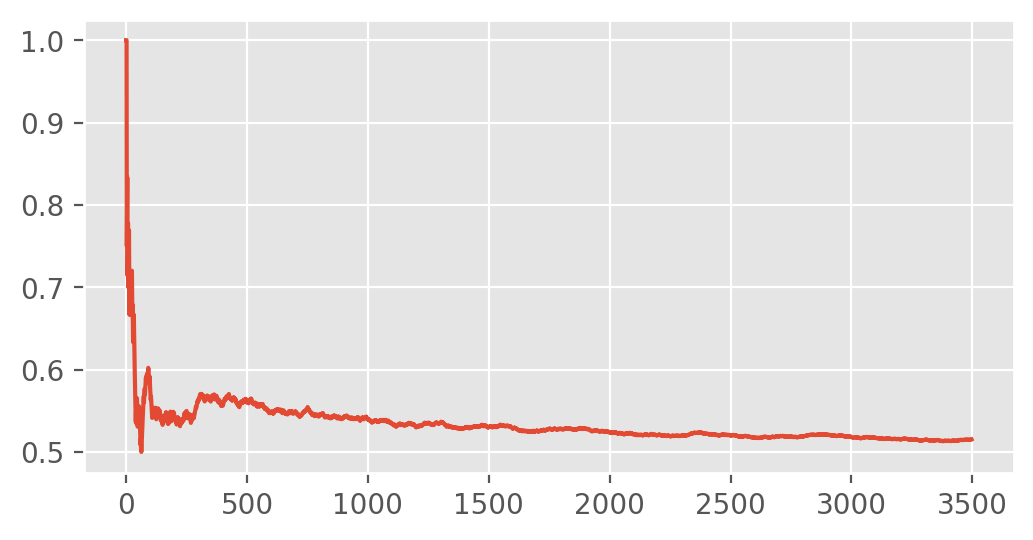

In [ ]:
scenario_configuration['period_duration'] = scenario_configuration['period_duration']
scenario = Scenario(scenario_configuration)
environment = My_environment(scenario)

obs = environment.reset()

done = False
while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = environment.step(action)

print(environment.scenario.cumulated_sfc_energy_consumption)
print(environment.scenario.number_of_sfc_requests_sucess/environment.scenario.number_of_sfc_requests)
plt.plot(environment.scenario.acceptance_ratio)

# New Experiments

In [ ]:
#@title Connecting to Drive
from google.colab import drive 
drive.mount('/content/gdrive')

path = 'gdrive/My Drive/Doutorado/reinforcement_learning/super_computing_paper/results/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#@title Creating and training the agent (function)
import os
import shutil
import pandas as pd


from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2, A2C
from stable_baselines.bench import Monitor

def train_test_agent(number_of_steps_to_train, model_type_name,scenario_configuration, repetitions,algorithm_path,delete_old_files,save_files,
                     gamma, learning_rate, save_rewards,train_customers,train_resources):
  
  # print('Agent type:',model_type_name)

  model_type = PPO2

  if model_type_name == 'A2C':
    model_type = A2C
  
  # algorithm_path = path+model_type_name+'/'
  # algorithm_path = path+'/customers_'+str(scenario_configuration['customers_number'])+'_resources_'+str(scenario_configuration['resources'][0])+'/'+model_type_name+'/'
  

  if delete_old_files:
    if os.path.exists(algorithm_path) and delete_old_files:
      shutil.rmtree(algorithm_path) # to remove old files

  if not os.path.exists(algorithm_path) and save_files: 
    # print('creating path...',algorithm_path) 
    os.makedirs(algorithm_path)

  file_name_metrics = algorithm_path+model_type_name+'_metrics.csv'
  if save_rewards:
    file_name_cumulative_reward = algorithm_path+model_type_name+'_cumulative_rewards.csv'
  
  
  first = 0
  if os.path.exists(file_name_metrics) and save_files:
    df_metrics = pd.read_csv(file_name_metrics)
    if save_rewards:
      df_cumulative_rewards = pd.read_csv(file_name_cumulative_reward)
    
    first = df_metrics.shape[0]
  else:
    df_metrics = pd.DataFrame(columns=['iteration','sfc_requests','sucess','sucess_sla_broken','avg_energy_consumption','customers_impacted'])
    df_cumulative_rewards = pd.DataFrame()
  
  
  test_customers = scenario_configuration['customers_number']
  test_resources = scenario_configuration['resources']

  for x in range(first,repetitions):
    print('iteration:',x+1)
    #scenario_configuration['generate_av_threshold'] = True # for the training, new availability thresholds are generated
    
    scenario_configuration['customers_number'] = train_customers
    scenario_configuration['resources'] = train_resources
    
    scenario = Scenario(scenario_configuration)
    environment = My_environment(scenario)

    # check_env(environment)
    
    verbose=0
    model = model_type('MlpPolicy', environment, verbose=verbose, gamma=gamma, learning_rate=learning_rate)
    # model = model_type(policy='MlpPolicy', env=environment, gamma=0.99, learning_rate=0.0005, buffer_size=50000, exploration_fraction=0.2, exploration_final_eps=0.02, exploration_initial_eps=1.0, train_freq=1, batch_size=32, double_q=True, learning_starts=1000, target_network_update_freq=500, prioritized_replay=False, prioritized_replay_alpha=0.6, prioritized_replay_beta0=0.4, prioritized_replay_beta_iters=None, prioritized_replay_eps=1e-06, param_noise=False, n_cpu_tf_sess=None, verbose=verbose, tensorboard_log=None, _init_setup_model=True, policy_kwargs=None, full_tensorboard_log=False, seed=None)
    # print('Training...')

    model.learn(total_timesteps=number_of_steps_to_train)

    if save_rewards:
      df_cumulative_rewards[x] = environment.cumulative_reward_list

    # plt.plot(environment.resources_log)
    # plt.plot(environment.cumulative_reward_list)
    

    # TESTING
    
    # scenario_configuration['print_log'] = False
    
    scenario_configuration['generate_av_threshold'] = False # for the testing, the fixed availability threshold is considered
    
    scenario_configuration['customers_number'] = test_customers
    scenario_configuration['resources'] = test_resources
    
    scenario = Scenario(scenario_configuration)

    environment = My_environment(scenario)

    obs = environment.reset()

    
    done = False
    i=0
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = environment.step(action)

        # cumulated_reward += reward
        # cumulated_reward_list.append(cumulated_reward)
        # if i % 1000 == 0:
          # print(i,'reward',reward)
          # environment.render()
        i+=1
    
    avg_energy_consumption = environment.scenario.cumulated_sfc_energy_consumption/(environment.scenario.number_of_sfc_requests_sucess_sla_broken+environment.scenario.number_of_sfc_requests_sucess)
    results_df = pd.DataFrame([[x+1,environment.scenario.number_of_sfc_requests,environment.scenario.number_of_sfc_requests_sucess,environment.scenario.number_of_sfc_requests_sucess_sla_broken,avg_energy_consumption,len(environment.scenario.customers_impacted)]],
                              columns=['iteration','sfc_requests','sucess','sucess_sla_broken','avg_energy_consumption','customers_impacted'])
    
    df_metrics = df_metrics.append(pd.DataFrame(results_df))
    
    # print('number of sfc requests:',environment.scenario.number_of_sfc_requests,'number of sucess:',environment.scenario.number_of_sfc_requests_sucess,'->',environment.scenario.number_of_sfc_requests_sucess/environment.scenario.number_of_sfc_requests*100,'%')
    # print('number of sfc requests:',environment.scenario.number_of_sfc_requests,'number of sucess (SLA broken):',environment.scenario.number_of_sfc_requests_sucess_sla_broken,'->',environment.scenario.number_of_sfc_requests_sucess_sla_broken/environment.scenario.number_of_sfc_requests*100,'%')
    
    # print('Average SFC energy consumption:',avg_energy_consumption)
    
    # print('customers impacted:',len(environment.scenario.customers_impacted))
    # for x in environment.scenario.customers_impacted:
    #   print('customer:',x,'impacted:',environment.scenario.customers_impacted[x])
  
    if save_files:
      df_metrics.to_csv(file_name_metrics,index=False)
      if save_rewards:
        df_cumulative_rewards.to_csv(file_name_cumulative_reward,index=False)#'''
  



In [ ]:
#@title Parametrization

#------------------------------------------------------------------------
# https://edisciplinas.usp.br/pluginfile.php/2699174/mod_resource/content/1/modsim06.pdf

scenario_configuration = {
    'percentage_variation':0.1,
    'dcs':1,
    'servers':[28], # servers per dc
    'resources':[10], # vm limit per dcs (for now, all servers are similar)
    'servers_mttf':[8760], # mttf of servers for each data center
    'servers_mttr':[1.667], # mttr of servers for each data center
    'vms_mttf':[2880],# mttf of software for each data center
    'vms_mttr':[0.17],# mttr of software for each data center
    'energy_consumption':[40+30.17],
    'maximum_redundant_vms':4,

    'vnf_templates':[
         {'name':'firewall','cost':1},
         {'name':'IDS','cost':1},
         {'name':'WAN-opt','cost':4}
    ],
    'customers_number': 5,
    'customers':[
        {'sfc_templates':[{'vnf_templates':[0,1]}], 
          # queue stability: λ < mμ
          'arrival_rate':(4/100),
          'departure_rate':(1/1000),
          'availability_threshold':0.99,
          'traffic_flow':{}}
    ],
    'generate_av_threshold':False,
    'period_duration':8760,
    'print_log':False
}

# path = 'gdrive/My Drive/Doutorado/reinforcement_learning/super_computing_paper/results/'
path = 'results/'

# number_of_steps_to_train = scenario_configuration['period_duration']*10
number_of_steps_to_train = 300000
repetitions = 15

model_type_name = 'a2c'.upper() # A2C, PPO2
gamma = 0.99
learning_rate = 0.00025 # dqn = 0.0005, PPO2 = 0.00025, A2C = 0.0007

delete_old_files = False
save_files = True 

save_rewards = True

path += 'parametrization/'

train_customers = scenario_configuration['customers_number']
train_resources = scenario_configuration['resources']

for learning_rate in [0.00005, 0.00025,0.0005,0.00075]:
  for gamma in [0.99, 0.85, 0.9, 0.95]:
  
    print('-----------------------------------------------')
    print(model_type_name,'gamma',gamma,'learning_rate',learning_rate)
    
    algorithm_path = path+model_type_name+'/'+'gamma_'+str(gamma)+'_learning_rate_'+str(learning_rate)+'/'

    train_test_agent(number_of_steps_to_train,
                     model_type_name,scenario_configuration,
                     repetitions,algorithm_path,delete_old_files,
                     save_files,gamma,learning_rate,save_rewards,
                     train_customers,train_resources)
print('Done!')

-----------------------------------------------
A2C gamma 0.99 learning_rate 5e-05
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
-----------------------------------------------
A2C gamma 0.85 learning_rate 5e-05
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
-----------------------------------------------
A2C gamma 0.9 learning_rate 5e-05
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
-----------------------------------------------
A2C gamma 0.95 learning_rate 5e-05
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
i

In [ ]:
#@title Creating the experiment config

dcs_number = 2
servers_number = 28

servers_list = [int(servers_number/dcs_number)]*dcs_number
servers_list[0] += servers_number-sum(servers_list)

server_mttf = 8760

server_mttf_list = [server_mttf]
porc = 0.1
temp_porc = porc
for x in range(dcs_number-1):
  server_mttf_temp = server_mttf*temp_porc
  server_mttf_list.append(server_mttf-server_mttf_temp)
  temp_porc = temp_porc + porc

# print(server_mttf_list)
scenario_configuration = {
    'percentage_variation':0.1,
    'dcs': dcs_number,
    'servers': servers_list, # servers per dc
    'resources':[10]*dcs_number, # vm limit per dcs (for now, all servers are similar)
    
    'servers_mttf':server_mttf_list, # mttf of servers for each data center
    'servers_mttr':[1.667]*dcs_number, # mttr of servers for each data center
    'vms_mttf':[2880]*dcs_number,# mttf of software for each data center
    'vms_mttr':[0.17]*dcs_number,# mttr of software for each data center
    'energy_consumption':[40+30.17]*dcs_number,
    'maximum_redundant_vms':4,

    'vnf_templates':[
         {'name':'firewall','cost':1},
         {'name':'IDS','cost':1},
         {'name':'WAN-opt','cost':4}
    ],
    'customers_number': 10,
    'customers':[
        {'sfc_templates':[{'vnf_templates':[0,1]}], 
          # queue stability: λ < mμ
          'arrival_rate':(4/100),
          'departure_rate':(1/1000),
          'availability_threshold':0.999, # 0.9995
          'traffic_flow':{}}
    ],
    'generate_av_threshold':False,
    'period_duration':8760,
    'print_log':False
}

# print(scenario_configuration['servers'])

number_of_steps_to_train = 500000
model_name = 'a2c'
model_name = model_name.upper()
experiment_variation = {
    
    'resources': [4, 8, 16, 32],
    'customers_number': [10, 20, 30, 40],
    'availability_threshold':[0.999,0.9992,0.9994,0.9996],
    'repetitions': 30

}

results_path = path+'scenario_variation/'
original_scenario_configuration = copy.deepcopy(scenario_configuration)


In [ ]:
# https://stackabuse.com/reading-and-writing-excel-files-in-python-with-the-pandas-library/
!pip install openpyxl xlsxwriter xlrd

In [ ]:
#title Training and testing the agent
import tensorflow as tf
from stable_baselines import PPO2, A2C
import pandas as pd
import os

if model_name == 'PPO2':
  model_type = PPO2
  gamma = 0.9
  learning_rate = 0.00005
else:
  model_type = A2C
  gamma = 
  learning_rate =

if not os.path.exists(results_path): 
    os.makedirs(results_path)

variation_key = [x for x in list(experiment_variation.keys()) if x not in ['repetitions']]


for key in variation_key:
  
  results_sheets = {}
  results_writer = pd.ExcelWriter(results_path+model_name+'_'+key+'_results.xlsx', engine='xlsxwriter')

  acceptance_ratio_sheets = {}
  acceptance_ratio_writer = pd.ExcelWriter(results_path+model_name+'_'+key+'_acceptance_ratio.xlsx', engine='xlsxwriter')
  
  scenario_configuration = copy.deepcopy(original_scenario_configuration)
  
  for value in experiment_variation[key]:

    if 'availability_threshold' == key:
      for customer in scenario_configuration['customers']:
        customer['availability_threshold'] = value
    elif 'customers_number' == key:  
      scenario_configuration[key] = value
    else: # resources == key
      scenario_configuration[key] = [value] * scenario_configuration['dcs']
    
    scenario = Scenario(scenario_configuration)
    environment = My_environment(scenario)
    
    # policy_kwargs = dict(act_fun=tf.nn.tanh, net_arch=[512,512])
    model = model_type('MlpPolicy', environment, 
                       gamma=gamma, learning_rate=learning_rate)#,
    #              policy_kwargs=policy_kwargs)

    print('Traininig agent → key',key,'value:',value)
    model.learn(total_timesteps=number_of_steps_to_train)
    # plt.plot(environment.resources_log)
    # plt.plot(environment.cumulative_reward_list)

    rows_list = []
    acceptance_ratio_pd = pd.DataFrame()
    for x in range(experiment_variation['repetitions']):
      scenario_configuration['period_duration'] = scenario_configuration['period_duration']*1
      scenario = Scenario(scenario_configuration)
      environment = My_environment(scenario)

      obs = environment.reset()

      done = False
      while not done:
          action, _states = model.predict(obs)
          obs, reward, done, info = environment.step(action)

      # print('Energy consumption:',environment.scenario.cumulated_sfc_energy_consumption)
      # print('Avg acceptance ratio:',environment.scenario.number_of_sfc_requests_sucess/environment.scenario.number_of_sfc_requests)

      row = {'energy_consumption':environment.scenario.cumulated_sfc_energy_consumption}
      row['sfc_sucess'] = environment.scenario.number_of_sfc_requests_sucess
      row['sfcs_number'] = environment.scenario.number_of_sfc_requests

      rows_list.append(row)
      acceptance_ratio_pd = pd.concat((acceptance_ratio_pd,pd.DataFrame(data={x:environment.scenario.acceptance_ratio})),ignore_index=True, axis=1)
      # plt.plot(environment.scenario.acceptance_ratio)
      # print('-----------------')

    results_sheets[str(value)] = pd.DataFrame(rows_list)
    acceptance_ratio_sheets[str(value)] = acceptance_ratio_pd
      
  for sheet_name in results_sheets.keys():
    results_sheets[sheet_name].to_excel(results_writer, sheet_name=sheet_name, index=False)
    acceptance_ratio_sheets[sheet_name].to_excel(acceptance_ratio_writer, sheet_name=sheet_name, index=False)
    
  results_writer.save()
  acceptance_ratio_writer.save() # '''


Traininig agent → key resources value: 4
Traininig agent → key resources value: 8
Traininig agent → key resources value: 16
Traininig agent → key resources value: 32
Traininig agent → key customers_number value: 10
Traininig agent → key customers_number value: 20
Traininig agent → key customers_number value: 30
Traininig agent → key customers_number value: 40
Traininig agent → key availability_threshold value: 0.999
Traininig agent → key availability_threshold value: 0.9992
Traininig agent → key availability_threshold value: 0.9994
Traininig agent → key availability_threshold value: 0.9996


# Experiments

In [ ]:
#@title Creating and training the agent (function)
import os
import shutil
import pandas as pd


from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2, A2C
from stable_baselines.bench import Monitor

def train_test_agent(number_of_steps_to_train, model_type_name,scenario_configuration, repetitions,algorithm_path,delete_old_files,save_files,
                     gamma, learning_rate, save_rewards,train_customers,train_resources):
  
  # print('Agent type:',model_type_name)

  model_type = PPO2

  if model_type_name == 'A2C':
    model_type = A2C
  
  # algorithm_path = path+model_type_name+'/'
  # algorithm_path = path+'/customers_'+str(scenario_configuration['customers_number'])+'_resources_'+str(scenario_configuration['resources'][0])+'/'+model_type_name+'/'
  

  if delete_old_files:
    if os.path.exists(algorithm_path) and delete_old_files:
      shutil.rmtree(algorithm_path) # to remove old files

  if not os.path.exists(algorithm_path) and save_files: 
    # print('creating path...',algorithm_path) 
    os.makedirs(algorithm_path)

  file_name_metrics = algorithm_path+model_type_name+'_metrics.csv'
  if save_rewards:
    file_name_cumulative_reward = algorithm_path+model_type_name+'_cumulative_rewards.csv'
  
  
  first = 0
  if os.path.exists(file_name_metrics) and save_files:
    df_metrics = pd.read_csv(file_name_metrics)
    if save_rewards:
      df_cumulative_rewards = pd.read_csv(file_name_cumulative_reward)
    
    first = df_metrics.shape[0]
  else:
    df_metrics = pd.DataFrame(columns=['iteration','sfc_requests','sucess','sucess_sla_broken','avg_energy_consumption','customers_impacted'])
    df_cumulative_rewards = pd.DataFrame()
  
  
  test_customers = scenario_configuration['customers_number']
  test_resources = scenario_configuration['resources']

  for x in range(first,repetitions):
    print('iteration:',x+1)
    scenario_configuration['generate_av_threshold'] = True # for the training, new availability thresholds are generated
    
    scenario_configuration['customers_number'] = train_customers
    scenario_configuration['resources'] = train_resources
    
    scenario = Scenario(scenario_configuration)
    environment = My_environment(scenario)

    # check_env(environment)
    
    verbose=0
    model = model_type('MlpPolicy', environment, verbose=verbose, gamma=gamma, learning_rate=learning_rate)
    # model = model_type(policy='MlpPolicy', env=environment, gamma=0.99, learning_rate=0.0005, buffer_size=50000, exploration_fraction=0.2, exploration_final_eps=0.02, exploration_initial_eps=1.0, train_freq=1, batch_size=32, double_q=True, learning_starts=1000, target_network_update_freq=500, prioritized_replay=False, prioritized_replay_alpha=0.6, prioritized_replay_beta0=0.4, prioritized_replay_beta_iters=None, prioritized_replay_eps=1e-06, param_noise=False, n_cpu_tf_sess=None, verbose=verbose, tensorboard_log=None, _init_setup_model=True, policy_kwargs=None, full_tensorboard_log=False, seed=None)
    # print('Training...')

    model.learn(total_timesteps=number_of_steps_to_train)

    if save_rewards:
      df_cumulative_rewards[x] = environment.cumulative_reward_list

    # plt.plot(environment.resources_log)
    # plt.plot(environment.cumulative_reward_list)
    

    # TESTING
    
    # scenario_configuration['print_log'] = False
    
    scenario_configuration['generate_av_threshold'] = False # for the testing, the fixed availability threshold is considered
    
    scenario_configuration['customers_number'] = test_customers
    scenario_configuration['resources'] = test_resources
    
    scenario = Scenario(scenario_configuration)

    environment = My_environment(scenario)

    obs = environment.reset()

    
    done = False
    i=0
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = environment.step(action)

        # cumulated_reward += reward
        # cumulated_reward_list.append(cumulated_reward)
        # if i % 1000 == 0:
          # print(i,'reward',reward)
          # environment.render()
        i+=1
    
    avg_energy_consumption = environment.scenario.cumulated_sfc_energy_consumption/(environment.scenario.number_of_sfc_requests_sucess_sla_broken+environment.scenario.number_of_sfc_requests_sucess)
    results_df = pd.DataFrame([[x+1,environment.scenario.number_of_sfc_requests,environment.scenario.number_of_sfc_requests_sucess,environment.scenario.number_of_sfc_requests_sucess_sla_broken,avg_energy_consumption,len(environment.scenario.customers_impacted)]],
                              columns=['iteration','sfc_requests','sucess','sucess_sla_broken','avg_energy_consumption','customers_impacted'])
    
    df_metrics = df_metrics.append(pd.DataFrame(results_df))
    
    # print('number of sfc requests:',environment.scenario.number_of_sfc_requests,'number of sucess:',environment.scenario.number_of_sfc_requests_sucess,'->',environment.scenario.number_of_sfc_requests_sucess/environment.scenario.number_of_sfc_requests*100,'%')
    # print('number of sfc requests:',environment.scenario.number_of_sfc_requests,'number of sucess (SLA broken):',environment.scenario.number_of_sfc_requests_sucess_sla_broken,'->',environment.scenario.number_of_sfc_requests_sucess_sla_broken/environment.scenario.number_of_sfc_requests*100,'%')
    
    # print('Average SFC energy consumption:',avg_energy_consumption)
    
    # print('customers impacted:',len(environment.scenario.customers_impacted))
    # for x in environment.scenario.customers_impacted:
    #   print('customer:',x,'impacted:',environment.scenario.customers_impacted[x])
  
    if save_files:
      df_metrics.to_csv(file_name_metrics,index=False)
      if save_rewards:
        df_cumulative_rewards.to_csv(file_name_cumulative_reward,index=False)#'''
  



In [ ]:
#@title Connecting to Drive
from google.colab import drive 
drive.mount('/content/gdrive')

In [ ]:
#@title Parametrization

#------------------------------------------------------------------------
# https://edisciplinas.usp.br/pluginfile.php/2699174/mod_resource/content/1/modsim06.pdf

scenario_configuration = {
    'percentage_variation':0.1,
    'dcs':1,
    'servers':[50], # servers per dc
    'resources':[10], # vm limit per dcs (for now, all servers are similar)
    'servers_mttf':[8760], # mttf of servers for each data center
    'servers_mttr':[1.667], # mttr of servers for each data center
    'vms_mttf':[2880],# mttf of software for each data center
    'vms_mttr':[0.17],# mttr of software for each data center
    'energy_consumption':[40+30.17],
    'maximum_redundant_vms':4,

    'vnf_templates':[
         {'name':'firewall','cost':1},
         {'name':'IDS','cost':1},
         {'name':'WAN-opt','cost':4}
    ],
    'customers_number': 5,
    'customers':[
        {'sfc_templates':[{'vnf_templates':[0,1]}], 
          # queue stability: λ < mμ
          'arrival_rate':(4/100),
          'departure_rate':(1/1000),
          'availability_threshold':0.95,
          'traffic_flow':{}}
    ],
    'period_duration':8760,
    'print_log':False
}

path = 'gdrive/My Drive/Doutorado/reinforcement_learning/results/'
# path = 'results/'

number_of_steps_to_train = scenario_configuration['period_duration']*10
repetitions = 30

model_type_name = 'ppo2'.upper() # A2C, PPO2
gamma = 0.99
learning_rate = 0.00025 # dqn = 0.0005, PPO2 = 0.00025, A2C = 0.0007

delete_old_files = False
save_files = True

save_rewards = True

path += 'parametrization/'

for gamma in [0.99, 0.85, 0.9, 0.95]:
  for learning_rate in [0.00005, 0.00025,0.0005,0.00075]:
    print('-----------------------------------------------')
    print(model_type_name,'gamma',gamma,'learning_rate',learning_rate)
    
    algorithm_path = path+model_type_name+'/'+'gamma_'+str(gamma)+'_learning_rate_'+str(learning_rate)+'/'

    train_test_agent(number_of_steps_to_train,model_type_name,scenario_configuration,repetitions,algorithm_path,delete_old_files,save_files,gamma,learning_rate,save_rewards)
print('Done!')

In [ ]:
#@title Scenario Variation (resources)

scenario_configuration = {
    'percentage_variation':0.1,
    'dcs':1,
    'servers':[50], # servers per dc
    'resources':[10], # vm limit per dcs (for now, all servers are similar)
    'servers_mttf':[8760], # mttf of servers for each data center
    'servers_mttr':[1.667], # mttr of servers for each data center
    'vms_mttf':[2880],# mttf of software for each data center
    'vms_mttr':[0.17],# mttr of software for each data center
    'energy_consumption':[40+30.17],
    'maximum_redundant_vms':4,

    'vnf_templates':[
         {'name':'firewall','cost':1},
         {'name':'IDS','cost':1},
         {'name':'WAN-opt','cost':4}
    ],
    'customers_number': 5,
    'customers':[
        {'sfc_templates':[{'vnf_templates':[0,1]}], 
          # queue stability: λ < mμ
          'arrival_rate':(4/100),
          'departure_rate':(1/1000),
          'availability_threshold':0.95,
          'traffic_flow':{}}
    ],
    'period_duration':8760,
    'print_log':False
}

path = 'gdrive/My Drive/Doutorado/reinforcement_learning/results/'
# path = 'results/'

number_of_steps_to_train = scenario_configuration['period_duration']*10
repetitions = 30

model_type_name = 'ppo2'.upper() # A2C, PPO2
gamma = 0.85
learning_rate = 0.00025 # dqn = 0.0005, PPO2 = 0.00025, A2C = 0.0007

delete_old_files = False
save_files = True

save_rewards = False

path += 'scenario_variation/'+model_type_name+'/resources/'

resources = [5,10,15,20]

train_customers = scenario_configuration['customers_number']
train_resources = scenario_configuration['resources']

for resource in resources:
  algorithm_path = path+str(resource)+'/'

  scenario_configuration['resources'] = [resource]

  print(model_type_name,'resources:',resource)

  train_test_agent(number_of_steps_to_train,model_type_name,scenario_configuration,repetitions,algorithm_path,delete_old_files,save_files,gamma,learning_rate,save_rewards,train_customers,train_resources)

print('Done!')

In [ ]:
#@title Scenario Variation (customers)

scenario_configuration = {
    'percentage_variation':0.1,
    'dcs':1,
    'servers':[50], # servers per dc
    'resources':[10], # vm limit per dcs (for now, all servers are similar)
    'servers_mttf':[8760], # mttf of servers for each data center
    'servers_mttr':[1.667], # mttr of servers for each data center
    'vms_mttf':[2880],# mttf of software for each data center
    'vms_mttr':[0.17],# mttr of software for each data center
    'energy_consumption':[40+30.17],
    'maximum_redundant_vms':4,

    'vnf_templates':[
         {'name':'firewall','cost':1},
         {'name':'IDS','cost':1},
         {'name':'WAN-opt','cost':4}
    ],
    'customers_number': 5,
    'customers':[
        {'sfc_templates':[{'vnf_templates':[0,1]}], 
          # queue stability: λ < mμ
          'arrival_rate':(4/100),
          'departure_rate':(1/1000),
          'availability_threshold':0.95,
          'traffic_flow':{}}
    ],
    'period_duration':8760,
    'print_log':False
}

path = 'gdrive/My Drive/Doutorado/reinforcement_learning/results/'
# path = 'results/'

number_of_steps_to_train = scenario_configuration['period_duration']*10
repetitions = 30

model_type_name = 'ppo2'.upper() # A2C, PPO2
gamma = 0.85
learning_rate = 0.00025  # dqn = 0.0005, PPO2 = 0.00025, A2C = 0.0007

delete_old_files = False
save_files = True

save_rewards = False

path += 'scenario_variation/'+model_type_name+'/customers_number/'

# customers_number = [2,4,6,8,10]
customers_number = [4,6,8,16,32]

train_customers = scenario_configuration['customers_number']
train_resources = scenario_configuration['resources']

for number in customers_number:
  algorithm_path = path+str(number)+'/'

  scenario_configuration['customers_number'] = number

  print(model_type_name,'customers_number:',number)

  train_test_agent(number_of_steps_to_train,model_type_name,scenario_configuration,repetitions,algorithm_path,delete_old_files,save_files,gamma,learning_rate,save_rewards,train_customers,train_resources)

print('Done!')

In [ ]:
#@title Scenario Variation (av threshold)

scenario_configuration = {
    'percentage_variation':0.1,
    'dcs':1,
    'servers':[50], # servers per dc
    'resources':[10], # vm limit per dcs (for now, all servers are similar)
    'servers_mttf':[8760], # mttf of servers for each data center
    'servers_mttr':[1.667], # mttr of servers for each data center
    'vms_mttf':[2880],# mttf of software for each data center
    'vms_mttr':[0.17],# mttr of software for each data center
    'energy_consumption':[40+30.17],
    'maximum_redundant_vms':4,

    'vnf_templates':[
         {'name':'firewall','cost':1},
         {'name':'IDS','cost':1},
         {'name':'WAN-opt','cost':4}
    ],
    'customers_number': 5,
    'customers':[
        {'sfc_templates':[{'vnf_templates':[0,1]}], 
          # queue stability: λ < mμ
          'arrival_rate':(4/100),
          'departure_rate':(1/1000),
          'availability_threshold':0.95,
          'traffic_flow':{}}
    ],
    'period_duration':8760,
    'print_log':False
}

path = 'gdrive/My Drive/Doutorado/reinforcement_learning/results/'
# path = 'results/'

number_of_steps_to_train = scenario_configuration['period_duration']*10
repetitions = 30

model_type_name = 'ppo2'.upper() # A2C, PPO2
gamma = 0.85
learning_rate = 0.00025  # dqn = 0.0005, PPO2 = 0.00025, A2C = 0.0007

delete_old_files = False
save_files = True

save_rewards = False

path += 'scenario_variation/'+model_type_name+'/availability_threshold/'

av_thresholds = [0.96,0.97,0.98,0.99]

train_customers = scenario_configuration['customers_number']
train_resources = scenario_configuration['resources']

for av_threshold in av_thresholds:
  algorithm_path = path+str(av_threshold)+'/'

  scenario_configuration['customers'][0]['availability_threshold'] = av_threshold

  print(model_type_name,'availability_threshold:',av_threshold)

  train_test_agent(number_of_steps_to_train,model_type_name,scenario_configuration,repetitions,algorithm_path,delete_old_files,save_files,gamma,learning_rate,save_rewards,train_customers,train_resources)

print('Done!')

PPO2 availability_threshold: 0.96
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
PPO2 availability_threshold: 0.97
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
PPO2 availability_threshold: 0.98
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
PPO2 availability_threshold: 0.99
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
Done!
